In [1]:
import pandas as pd
from scipy import stats
from statsmodels.stats.weightstats import zconfint
import scipy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('credit_card_default_analysis.csv')
df.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [3]:
df.shape

(30000, 25)

### TASK 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [4]:
df.columns

Index([u'ID', u'LIMIT_BAL', u'SEX', u'EDUCATION', u'MARRIAGE', u'AGE',
       u'PAY_0', u'PAY_2', u'PAY_3', u'PAY_4', u'PAY_5', u'PAY_6',
       u'BILL_AMT1', u'BILL_AMT2', u'BILL_AMT3', u'BILL_AMT4', u'BILL_AMT5',
       u'BILL_AMT6', u'PAY_AMT1', u'PAY_AMT2', u'PAY_AMT3', u'PAY_AMT4',
       u'PAY_AMT5', u'PAY_AMT6', u'default'],
      dtype='object')

### описание полей:

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

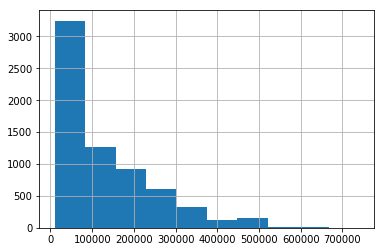

In [5]:
df[df['default']==1]['LIMIT_BAL'].hist()

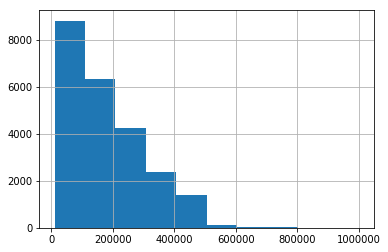

In [6]:
df[df['default']==0]['LIMIT_BAL'].hist()

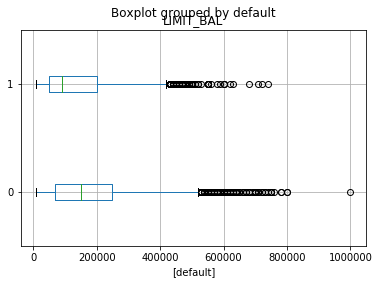

In [7]:
df[['LIMIT_BAL', 'default']].boxplot(by='default', vert=False)

=> гистограмма размера кредитного лимита клиентов вернувших кредит имеет более тяжелый хвост

#### a) 
Проверяем гипотезу о равенстве мидианных значений:

- **H_0:** df[df['default']==0]['LIMIT_BAL'] == df[df['default']==1]['LIMIT_BAL']
- **H_a:** H_0: df[df['default']==0]['LIMIT_BAL'] == df[df['default']==1]['LIMIT_BAL'] + delta; delta != 0

alpha = 0.05

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
def_1 = map(np.median, get_bootstrap_samples(df[df['default']==1]['LIMIT_BAL'].values, 1000))
def_0 = map(np.median, get_bootstrap_samples(df[df['default']==0]['LIMIT_BAL'].values, 1000))

print "95% confidence interval for default=1 median credit limit:",  stat_intervals(def_1, 0.05)
print "95% confidence interval for default=0 median credit limit:",  stat_intervals(def_0 , 0.05)

95% confidence interval for default=1 median credit limit: [80000. 90000.]
95% confidence interval for default=0 median credit limit: [150000. 150000.]


Интервальные оценки медиан не пересекаются, что позволяет нам отвергнуть нулевую гипотезу о о равенстве мидианных значений на уровне значимости 0.05 в пользу альтернативной гипотезы

 #### b)
 проверяем гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [10]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [11]:
print "p-value: %f" % permutation_test(df[df['default']==0]['LIMIT_BAL'], df[df['default']==1]['LIMIT_BAL'], max_permutations = 10000)

p-value: 0.000100


p_value < alpha, что позволяет нам отвергнуть нулевую гипотезу о равенстве распределений по перестановочному критерию на уровне значимости 0.05 в пользу альтернативной гипотезы. 

Скорее всего имеет место обратная зависимость - клиентам, чья вероятность вернуть кредит по подсчетам банка больше, предоставляли более широкий кредитный лимит. Отсюда и сдвиг медианы

### TASK 2

Пол (SEX): Проверьте гипотезу о том, что **гендерный состав группы людей вернувших и не вернувших** кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [12]:
df_0=df[df['default']==0]['SEX']-1
df_1=df[df['default']==1]['SEX']-1

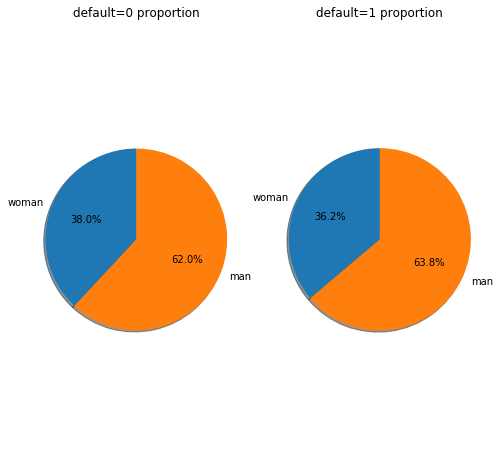

In [13]:
labels = 'woman', 'man'
sizes_0 = [sum(df_0), df_0.shape[0]]
sizes_1 = [sum(df_1), df_1.shape[0]]

fig1, (ax1, ax2) = plt.subplots(1, 2)
fig1.set_figheight(8)
fig1.set_figwidth(8)
ax1.pie(sizes_0, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('default=0 proportion')

ax2.pie(sizes_1, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')
ax2.set_title('default=1 proportion')

plt.show()

- H_0: P(woman|default=1) == P(woman|default=0)
- H_a: P(woman|default=1) != P(woman|default=0)

alpha = 0.05

In [14]:
from statsmodels.stats.proportion import proportion_confint

conf_interval_banner_def_0 = proportion_confint(sum(df_0), 
                                            df_0.shape[0],
                                            method = 'wilson')
conf_interval_banner_def_1 = proportion_confint(sum(df_1), 
                                            df_1.shape[0],
                                            method = 'wilson')

print 'interval for default=0 [%f, %f]' % conf_interval_banner_def_0
print 'interval for default=1 [%f, %f]' % conf_interval_banner_def_1

interval for default=0 [0.607890, 0.620373]
interval for default=1 [0.555102, 0.578938]


In [15]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)
    
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [16]:
print "95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(df_0, df_1)

95% confidence interval for a difference between proportions: [0.033635, 0.060548]


In [17]:
proportions_diff_z_test(proportions_diff_z_stat_ind(df_0, df_1))

4.472866521609831e-12

P_value < alpha, значит отвергаем нашу нулевую гипотезу о равенстве долей женщин в двух подвыборках в пользу альтернативной. 95% интервальные оценки не пересекаются, а их разница не содержит нуля, что говорит о различии долей в подвыборках. С практической точки зрения мы можем утверждать, что в мужчины на 3-6% более склонны к невозврату кредита, чем женщины

### TASK 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [18]:
df_0=df[df['default']==0]['EDUCATION']
df_1=df[df['default']==1]['EDUCATION']

In [19]:
cross_table=np.zeros([2,7], dtype='int')

for i in range(7):
    cross_table[0,i] = np.sum(df_0==i)
for i in range(7):
    cross_table[1,i] = np.sum(df_1==i)

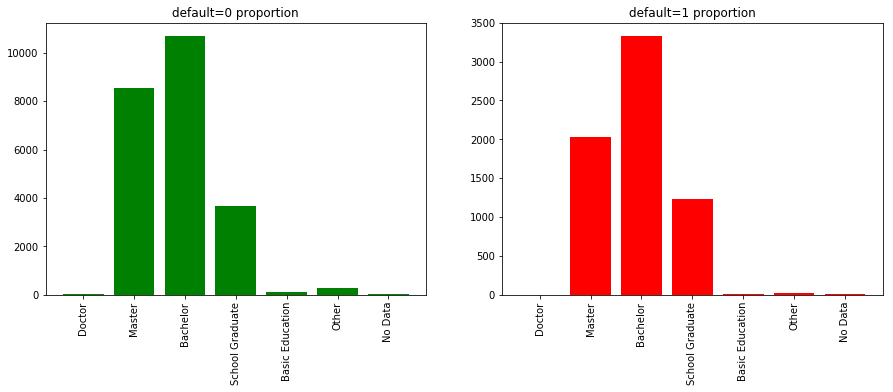

In [20]:
labels = ('Doctor', 'Master', 'Bachelor', 'School Graduate', 'Basic Education', 'Other', 'No Data')

fig1, (ax1, ax2) = plt.subplots(1, 2)
fig1.set_figheight(5)
fig1.set_figwidth(15)

ax1.bar(labels, cross_table[0], color='g')
#ax1.axis('equal')
ax1.set_title('default=0 proportion')
ax1.tick_params(axis='x', labelrotation=90)

ax2.bar(labels, cross_table[1], color='r')
#ax2.axis('equal')
ax2.set_title('default=1 proportion')
ax2.tick_params(axis='x', labelrotation=90)

plt.show()

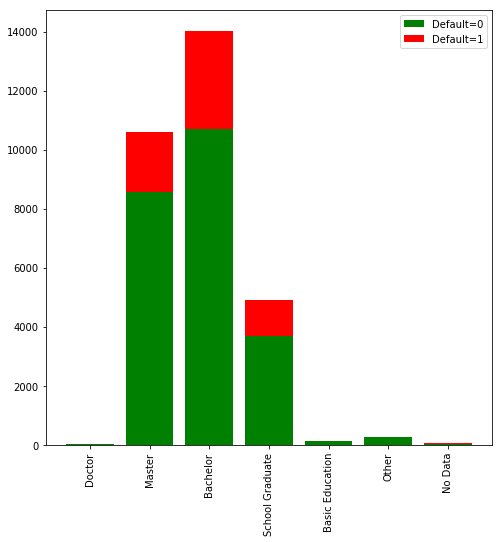

In [21]:
df_e=df.groupby('EDUCATION').size()

labels = ('Doctor', 'Master', 'Bachelor', 'School Graduate', 'Basic Education', 'Other', 'No Data')
fig1, ax1 = plt.subplots()
fig1.set_figheight(8)
fig1.set_figwidth(8)

ax1.bar(labels, cross_table[0], color='g')
ax1.bar(labels, cross_table[1], bottom=cross_table[0], color='r')
#ax1.axis('equal')
#ax1.set_title('default=0 proportion')
plt.legend(('Default=0', 'Default=1'))
ax1.tick_params(axis='x', labelrotation=90)

In [183]:
chi2, p, dof, ex = scipy.stats.chi2_contingency(cross_table)
print 'Критерий Хи квадрат: статистика =',chi2,'     уровень значимости =', p

Критерий Хи квадрат: статистика = 27.5094090929579      уровень значимости = 1.5633210355976673e-07


Уровень значимости для полученной статистики Хи квадрат (1.2e-32) значительно ниже 0.05, что позволяет уверенно отвергнуть гипотезу о том, что признаки независимы

In [23]:
print 'Таблица сопряженности, где значения ячеек - наблюдаемое количество человек'
pd.DataFrame(cross_table, 
             columns=['Doctor', 'Master', 'Bachelor', 'School Graduate', 'Basic Education', 'Other', 'No Data'], 
             index=['default=0', 'default=1'])

Таблица сопряженности, где значения ячеек - наблюдаемое количество человек


,Doctor,Master,Bachelor,School Graduate,Basic Education,Other,No Data
default=0,14,8549,10700,3680,116,262,43
default=1,0,2036,3330,1237,7,18,8


In [24]:
print 'Таблица сопряженности, где значения ячеек - ожидаемое количество человек'
pd.DataFrame(ex.astype(int), 
             columns=['Doctor', 'Master', 'Bachelor', 'School Graduate', 'Basic Education', 'Other', 'No Data'], 
             index=['default=0', 'default=1'])

Таблица сопряженности, где значения ячеек - ожидаемое количество человек


,Doctor,Master,Bachelor,School Graduate,Basic Education,Other,No Data
default=0,10,8243,10926,3829,95,218,39
default=1,3,2341,3103,1087,27,61,11


Cоставим таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек

In [25]:
print 'Таблица сопряженности, где значения ячеек - разность между наблюдаемым и ожидаемым количеством человек'
pd.DataFrame(cross_table-ex.astype(int), 
             columns=['Doctor', 'Master', 'Bachelor', 'School Graduate', 'Basic Education', 'Other', 'No Data'], 
             index=['default=0', 'default=1'])

Таблица сопряженности, где значения ячеек - разность между наблюдаемым и ожидаемым количеством человек


,Doctor,Master,Bachelor,School Graduate,Basic Education,Other,No Data
default=0,4,306,-226,-149,21,44,4
default=1,-3,-305,227,150,-20,-43,-3


*Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?*

Для приведения значения ячеек к одному маштабу, можно расчитать процент невозврата и отклонение от общего процента невозврата для каждой таблицы

In [26]:
default_rate = cross_table[1,:].sum()/cross_table.sum().astype(float)
print u"Доля невозврата по всей наблюдаемой выборке " + str(default_rate*100) + " %"

Доля невозврата по всей наблюдаемой выборке 22.12 %


In [27]:
cross_table_def_p=[]
for i in cross_table.T:
    cross_table_def_p.append(i[1]/float(i.sum()))

In [28]:
ex_p=[]
for i in ex.T:
    ex_p.append(i[1]/float(i.sum()))

In [29]:
cross_table_def_p-default_rate

array([-0.2212    , -0.02885234,  0.01614854,  0.03037616, -0.16428943,
       -0.15691429, -0.06433725])

In [30]:
data_p=np.around(np.vstack((cross_table_def_p, ex_p, cross_table_def_p-default_rate)), 2)

In [31]:
table_edu=pd.DataFrame(data_p, 
             columns=['Doctor', 'Master', 'Bachelor', 'School Graduate', 'Basic Education', 'Other', 'No Data'], 
             index=['Expremental default prob.', 'Expected default prob.', 'The diff.'])

table_edu

,Doctor,Master,Bachelor,School Graduate,Basic Education,Other,No Data
Expremental default prob.,0.00,0.19,0.24,0.25,0.06,0.06,0.16
Expected default prob.,0.22,0.22,0.22,0.22,0.22,0.22,0.22
The diff.,-0.22,-0.03,0.02,0.03,-0.16,-0.16,-0.06


Из таблицы выше предлагаю отбросить значения столбцов, с количевством элементов в оригинальном датасете менее 40 штук

In [32]:
table_edu[['Master', 'Bachelor', 'School Graduate', 'Basic Education', 'Other']]

,Master,Bachelor,School Graduate,Basic Education,Other
Expremental default prob.,0.19,0.24,0.25,0.06,0.06
Expected default prob.,0.22,0.22,0.22,0.22,0.22
The diff.,-0.03,0.02,0.03,-0.16,-0.16


*Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?*

Исходя из таблицы выше можно сделать вывод, что наличие базового образования может служить наилучшим индикатором того, что человек отдаст долг. В то же время школьного образования значительно повышает риск невозврата по кредиту

### Task 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [33]:
print df['MARRIAGE'].value_counts()
print ('MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных)')

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64
MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных)


In [34]:
df_m=df.groupby(['default', 'MARRIAGE']).size()

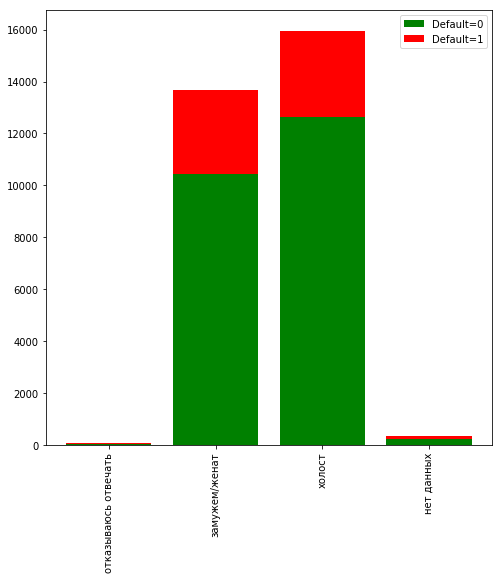

In [37]:
labels = (u'отказываюсь отвечать', u'замужем/женат', u'холост', u'нет данных')
fig1, ax1 = plt.subplots()
fig1.set_figheight(8)
fig1.set_figwidth(8)

ax1.bar(labels, df_m[0], color='g')
ax1.bar(labels, df_m[1], bottom=df_m[0], color='r')
#ax1.axis('equal')
#ax1.set_title('default=0 proportion')
plt.legend(('Default=0', 'Default=1'))
ax1.tick_params(axis='x', labelrotation=90)

Значения признака "отказываюсь отвечать" и "нет данных" малочислены и не несут информации - удаляем их из дальнейшего рассмотрения.

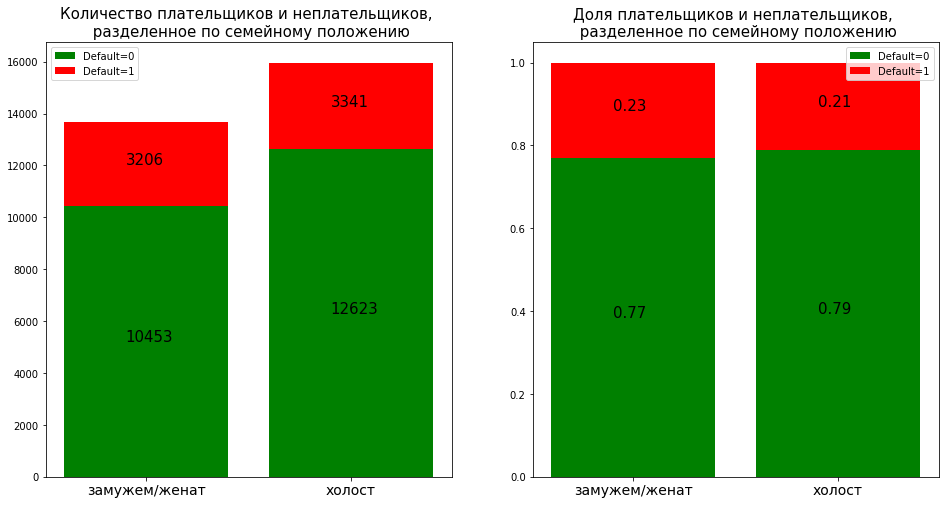

In [154]:
labels = (u'замужем/женат', u'холост')
fig1, (ax1, ax2) = plt.subplots(1,2)
fig1.set_figheight(8)
fig1.set_figwidth(16)


ax1.bar(labels, df_m[0][1:3], color='g')
ax1.bar(labels, df_m[1][1:3], bottom=df_m[0][1:3], color='r')
ax1.tick_params(axis='x', labelrotation=0, labelsize=14)
ax1.legend(('Default=0', 'Default=1'))
ax1.annotate(str(df_m[0][1]), (0-0.1, df_m[0][1]/2), size=15)
ax1.annotate(str(df_m[0][2]), (1-0.1, df_m[0][2]/2), size=15)
ax1.title.set_text(u'Количество плательщиков и неплательщиков, \n разделенное по семейному положению')
ax1.title.set_size(15)
ax1.annotate(str(df_m[1][1]), (0-0.1, df_m[0][1]+(df_m[1][1]/2)), size=15)
ax1.annotate(str(df_m[1][2]), (1-0.1, df_m[0][2]+(df_m[1][2]/2)), size=15)

sum_m=(df_m[1][1:3]+df_m[0][1:3]).astype(float)
df0_m_p=np.around(df_m[0][1:3]/sum_m,2)
df1_m_p=np.around(df_m[1][1:3]/sum_m,2)

ax2.bar(labels, df0_m_p, color='g')
ax2.bar(labels, df1_m_p, bottom=df0_m_p, color='r')

ax2.annotate(str(df0_m_p[1]), (0-0.1, df0_m_p[1]/2), size=15)
ax2.annotate(str(df0_m_p[2]), (1-0.1, df0_m_p[2]/2), size=15)

ax2.annotate(str(df1_m_p[1]), (0-0.1, df0_m_p[1]+(df1_m_p[1]/2)), size=15)
ax2.annotate(str(df1_m_p[2]), (1-0.1, df0_m_p[2]+(df1_m_p[2]/2)), size=15)


ax2.title.set_text(u'Доля плательщиков и неплательщиков, \n разделенное по семейному положению')
ax2.title.set_size(15)
ax2.tick_params(axis='x', labelrotation=0, labelsize=14)
ax2.legend(('Default=0', 'Default=1'))

На графиках видно, что доля неплательщиков больше среди женатых/замужних клиентов.

Далее, аналогично предыдущему заданию, планируется применить критерий Хи квадрат для проверки гипотезы о том, что семейное положение не влияет на то, вернет ли человек долг

In [166]:
cross_table = np.vstack((df_m[0][1:3], df_m[1][1:3]))

In [182]:
chi2, p, dof, ex = scipy.stats.chi2_contingency(cross_table)
print 'Критерий Хи квадрат: статистика =',chi2,'     уровень значимости =', p

Критерий Хи квадрат: статистика = 27.5094090929579      уровень значимости = 1.5633210355976673e-07


Уровень значимости для полученной статистики Хи квадрат (1.56e-7) значительно ниже 0.05, что позволяет уверенно отвергнуть гипотезу о том, что признаки независимы. 

Для того, чтобы измерить возможную связь переменных MARRIAGE и Deafault и посчитать ее значение, вычислим коэффициент корреляции Крэмера, меру взаимосвязи бинарных признаков

In [181]:
V = np.sqrt(chi2/cross_table.sum())
print V.round(2)

0.03


Полученное значение коэфициент корреляции Крамера весьма мало, что согласуется со слабой связью семейного положения с возвратом кредита.

### TASK 5
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [184]:
df_0=df[df['default']==0]['AGE']
df_1=df[df['default']==1]['AGE']

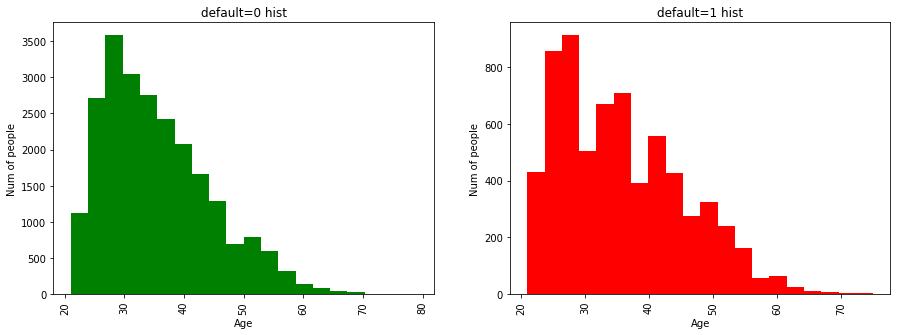

In [194]:
fig1, (ax1, ax2) = plt.subplots(1, 2)
fig1.set_figheight(5)
fig1.set_figwidth(15)

ax1.hist(df_0, color='g',bins=20)
#ax1.axis('equal')
ax1.set_title('default=0 hist')
ax1.set_xlabel('Age')
ax1.set_ylabel('Num of people')
ax1.tick_params(axis='x', labelrotation=90)

ax2.hist(df_1, color='r',bins=20)
#ax2.axis('equal')
ax2.set_title('default=1 hist')
ax2.set_xlabel('Age')
ax2.set_ylabel('Num of people')
ax2.tick_params(axis='x', labelrotation=90)

plt.show()

A) оценка медианных значений возрастов людей реализованная через бутстрап

In [195]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [201]:
df0_median_scores = map(np.median, get_bootstrap_samples(df_0.values, 1000))
df1_median_scores = map(np.median, get_bootstrap_samples(df_1.values, 1000))

print "difference between medians:", np.median(df_0.values) - np.median(df_1.values)
print "95% confidence interval for the ILEC median repair time:",  stat_intervals(df0_median_scores, 0.05)
print "95% confidence interval for the CLEC median repair time:",  stat_intervals(df1_median_scores, 0.05)

delta_median_scores = map(lambda x: x[1] - x[0], zip(df0_median_scores, df1_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

difference between medians: 0.0
95% confidence interval for the ILEC median repair time: [34. 34.]
95% confidence interval for the CLEC median repair time: [34. 35.]
95% confidence interval for the difference between medians [0. 1.]


95%-ые доверительные интервалы для оценок медиан двух подвыборок пересекаются, доверительный интервал для разности медиан содержит нуль, что не позволяет нам сделать вывод, что медианы подвыборок различны

b) Проверяем равенство распределений с помощью непараметрического критерия проверки равенства средних Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

alpha = 0.05

In [203]:
stats.mannwhitneyu(df_0, df_1, alternative='two-sided')

MannwhitneyuResult(statistic=76966879.5, pvalue=0.3725035434898616)

p_value > alpha, что не позволяет нам отвергнуть нулевую гипотезу о равенстве распределений по заданному критерию на уровне значимости 0.05 в пользу альтернативной гипотезы. Возрастные характеристики двух групп схожи и нет возможности делать выводы о возврате/невозврате кридита по одному лишь возрасту